## **Example. Stratified sampling in pre-election polling**

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd
import scipy.stats as stats
import theano.tensor as tt
import arviz
import seaborn
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.style.use('seaborn-darkgrid')
plt.rc('font', size=12)

%config Inline.figure_formats = ['retina']

A survey of 1447 adults.

In [7]:
participants = 1447

This is the Table 8.2

In [8]:
data = pd.read_csv('data/cbs_survey.txt', sep=' ', skiprows=2, skipinitialspace=True, index_col=False)
data

,region,density,bush,dukakis,other,proportion
0,Northeast,I,0.298,0.617,0.085,0.032
1,Northeast,II,0.500,0.478,0.022,0.032
2,Northeast,III,0.467,0.413,0.120,0.115
3,Northeast,IV,0.464,0.522,0.014,0.048
4,Midwest,I,0.404,0.489,0.106,0.032
5,Midwest,II,0.447,0.447,0.106,0.065
6,Midwest,III,0.509,0.388,0.103,0.080
7,Midwest,IV,0.552,0.338,0.110,0.100
8,South,I,0.571,0.286,0.143,0.015
9,South,II,0.469,0.406,0.125,0.066


We need the number of people of each region and each candidate.

In [9]:
data_obs = data[['bush', 'dukakis', 'other']].to_numpy()
print(data_obs)

[[0.298 0.617 0.085]
 [0.5   0.478 0.022]
 [0.467 0.413 0.12 ]
 [0.464 0.522 0.014]
 [0.404 0.489 0.106]
 [0.447 0.447 0.106]
 [0.509 0.388 0.103]
 [0.552 0.338 0.11 ]
 [0.571 0.286 0.143]
 [0.469 0.406 0.125]
 [0.515 0.404 0.081]
 [0.555 0.352 0.093]
 [0.5   0.471 0.029]
 [0.532 0.351 0.117]
 [0.54  0.371 0.089]
 [0.554 0.361 0.084]]


In [10]:
proportion = data['proportion'].to_numpy() * participants
print(proportion)

[ 46.304  46.304 166.405  69.456  46.304  94.055 115.76  144.7    21.705
  95.502  98.396 182.322  33.281  76.691 124.442  82.479]


In [11]:
np.sum(proportion)

1444.106

In [12]:
print(data_obs.shape)
print(proportion.shape)

(16, 3)
(16,)


In [14]:
values = data_obs[:, :] * proportion.reshape(16, -1)
values = np.round(values)
np.sum(values)   # Check if the sum is equal to 1447

1447.0

### **Nonhierarchical model**

In [144]:
with pm.Model() as model_non_hiera:
    
    thetas = pm.Dirichlet('thetas', a=np.ones_like(data_obs), shape=(16, 3))
    post = pm.Multinomial('post', n=np.sum(values, axis=1), p=thetas, observed=values)

In [11]:
model_non_hiera.check_test_point()

thetas_stickbreaking__    -41.64
post                     -322.85
Name: Log-probability of test_point, dtype: float64

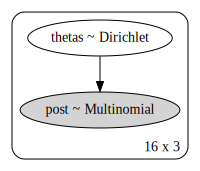

In [12]:
pm.model_to_graphviz(model_non_hiera)

In [13]:
with model_non_hiera:
    trace_1 = pm.sample(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetas]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:13<00:00, 1209.89draws/s]


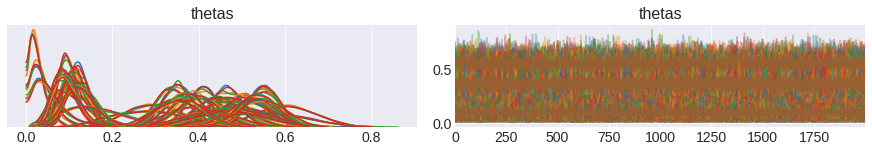

In [16]:
pm.traceplot(trace_1, var_names=['thetas']);

In [14]:
arviz.summary(trace_1)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"thetas[0,0]",0.300,0.064,0.184,0.421,0.000,0.000,19180.0,16774.0,19307.0,6091.0,1.0
"thetas[0,1]",0.600,0.068,0.476,0.731,0.000,0.000,20053.0,19440.0,20049.0,5982.0,1.0
"thetas[0,2]",0.100,0.042,0.030,0.177,0.000,0.000,17561.0,12188.0,18066.0,6011.0,1.0
"thetas[1,0]",0.489,0.072,0.354,0.623,0.000,0.000,23445.0,22381.0,23545.0,5592.0,1.0
"thetas[1,1]",0.470,0.072,0.338,0.606,0.000,0.000,21942.0,20049.0,22004.0,6000.0,1.0
"thetas[1,2]",0.041,0.028,0.001,0.091,0.000,0.000,16066.0,9055.0,16361.0,5270.0,1.0
"thetas[2,0]",0.465,0.039,0.390,0.537,0.000,0.000,17977.0,17356.0,17922.0,6509.0,1.0
"thetas[2,1]",0.412,0.038,0.339,0.483,0.000,0.000,19789.0,19706.0,19714.0,6207.0,1.0
"thetas[2,2]",0.124,0.025,0.077,0.170,0.000,0.000,18393.0,15598.0,18954.0,6378.0,1.0
"thetas[3,0]",0.458,0.058,0.351,0.564,0.000,0.000,18586.0,18308.0,18494.0,6064.0,1.0


Now, the goal is to reproduce the figure 8.1 (a).

In [25]:
with model_non_hiera:
    ppc_non_hiera = pm.sample_posterior_predictive(trace_1, samples=10_000, vars=[thetas, post])

100%|██████████| 10000/10000 [00:15<00:00, 666.41it/s]


In [26]:
ppc_non_hiera['thetas'].shape

(10000, 16, 3)

Just check if the column **proportion** (look at the data frame) is equal to what we got.

In [27]:
proportion / np.sum(proportion)

array([0.03206413, 0.03206413, 0.11523046, 0.04809619, 0.03206413,
       0.06513026, 0.08016032, 0.1002004 , 0.01503006, 0.06613226,
       0.06813627, 0.12625251, 0.02304609, 0.05310621, 0.08617234,
       0.05711423])

In [28]:
diff = []

for i in range(16):
    result = ppc_non_hiera['thetas'][:, i, 0] - ppc_non_hiera['thetas'][:, i, 1]
    diff.append(list(result))

In [29]:
diff = np.asarray(diff)
diff

array([[-0.38269827, -0.2111439 , -0.03313074, ..., -0.40320236,
        -0.28429534, -0.29398797],
       [-0.16225691,  0.10415002, -0.00290161, ..., -0.05570792,
         0.08606434, -0.09591687],
       [-0.05859063,  0.1490945 ,  0.07752748, ...,  0.03058629,
         0.08686482,  0.02734735],
       ...,
       [ 0.23776605,  0.17184184,  0.15313478, ...,  0.3966856 ,
         0.12764284,  0.20320234],
       [ 0.18947771,  0.05270173,  0.1134665 , ...,  0.08172745,
         0.18431356,  0.15733717],
       [ 0.30797976,  0.04437883,  0.06218116, ...,  0.1295049 ,
         0.21549409,  0.14776103]])

In [30]:
result = np.sum(diff.T * proportion / np.sum(proportion), axis=1)

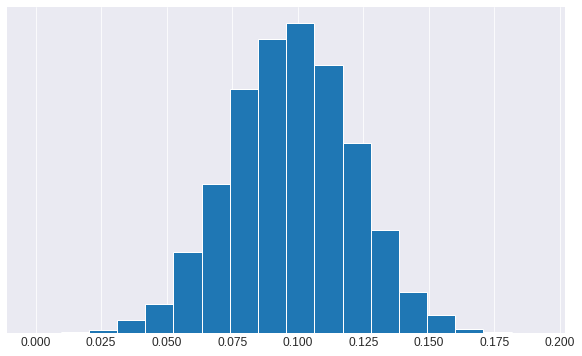

In [31]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(result, bins=18, edgecolor='w', density=True)
plt.yticks([]);

The figure is almost the same!

### **Hierarchichal model**

The authors are using other parameters, so we need to find the number of people for $\alpha_{1j}$ and $\alpha_{2j}$.

In [15]:
alpha_2j = np.round((1 - data['other'].to_numpy()) * data.proportion.to_numpy() * participants) #Not a probability as you may see
print(alpha_2j)

[ 42.  45. 146.  68.  41.  84. 104. 129.  19.  84.  90. 165.  32.  68.
 113.  76.]


In [16]:
alpha_1j = values[:, 0] / (values[:, 0] + values[:, 1]) * data.proportion.to_numpy() * participants #Not a probability as you may see
print(alpha_1j)

[ 15.07572093  23.66648889  88.29653061  32.68517647  20.94704762
  47.0275      65.67153846  89.73643411  14.47        51.16178571
  55.14501099 111.60316364  17.14475758  46.24016176  73.78419469
  49.9215    ]


In [17]:
new_values = np.round(np.stack([alpha_1j, alpha_2j], axis=1))
print(new_values)

[[ 15.  42.]
 [ 24.  45.]
 [ 88. 146.]
 [ 33.  68.]
 [ 21.  41.]
 [ 47.  84.]
 [ 66. 104.]
 [ 90. 129.]
 [ 14.  19.]
 [ 51.  84.]
 [ 55.  90.]
 [112. 165.]
 [ 17.  32.]
 [ 46.  68.]
 [ 74. 113.]
 [ 50.  76.]]


In [121]:
with pm.Model() as model_hier:
    
    packed_L = pm.LKJCholeskyCov('packed_L', n=2, eta=2., sd_dist=pm.HalfCauchy.dist(10))

    L = pm.expand_packed_triangular(2, packed_L)
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))

    mu = pm.Normal('mu', 0, 20, shape=2)
#     mu = pm.Normal('mu', 0., 10., shape=2, testval=new_values.mean(axis=0))
    beta = pm.MvNormal('beta', mu=mu, chol=L, shape=(16, 2))
    
    alpha = pm.invlogit(beta)
    
    alphas = pm.Dirichlet('alphas', a=alpha, shape=(16, 2))

    post = pm.Multinomial('post', n=np.sum(new_values, axis=1), p=alphas, observed=new_values)

In [122]:
model_hier.check_test_point()

packed_L_cholesky-cov-packed__     -5.24
mu                                 -7.83
beta                              -29.41
alphas_stickbreaking__            -29.41
post                             -105.64
Name: Log-probability of test_point, dtype: float64

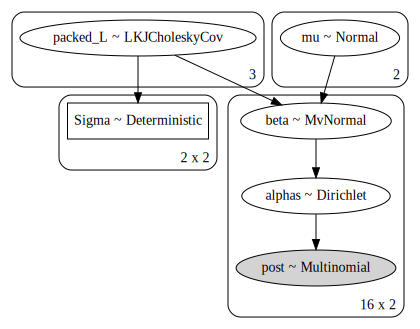

In [123]:
pm.model_to_graphviz(model_hier)

In [124]:
with model_hier:
    trace_2 = pm.sample(draws=2_000, tune=5_000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alphas, beta, mu, packed_L]
INFO:pymc3:NUTS: [alphas, beta, mu, packed_L]
Sampling 4 chains, 1,506 divergences: 100%|██████████| 28000/28000 [12:42<00:00, 15.20draws/s] 
There were 145 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 145 divergences after tuning. Increase `target_accept` or reparameterize.
There were 440 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 440 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.600283428310378, but should be close to 0.8. Try to increase the number of tuning steps.
There were 183 divergences after tuni

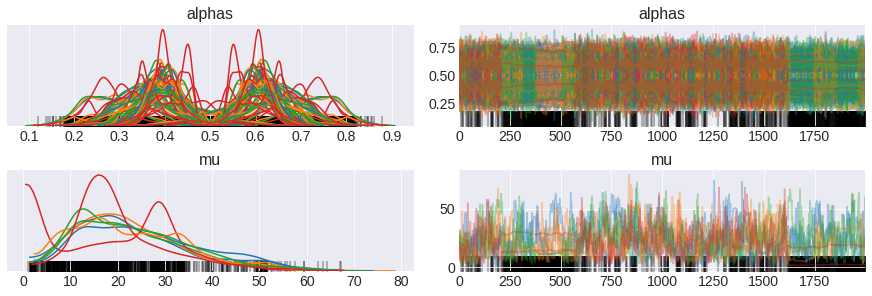

In [126]:
pm.traceplot(trace_2, var_names=['alphas', 'mu']);

In [127]:
arviz.summary(trace_2, var_names=['alphas', 'mu'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"alphas[0,0]",0.271,0.056,0.168,0.381,0.002,0.001,1023.0,917.0,1048.0,706.0,1.02
"alphas[0,1]",0.729,0.056,0.619,0.832,0.002,0.001,1023.0,1023.0,1048.0,706.0,1.02
"alphas[1,0]",0.358,0.057,0.254,0.460,0.004,0.003,235.0,235.0,258.0,2014.0,1.02
"alphas[1,1]",0.642,0.057,0.540,0.746,0.004,0.003,235.0,234.0,258.0,2014.0,1.02
"alphas[2,0]",0.377,0.030,0.319,0.433,0.002,0.001,279.0,279.0,321.0,2005.0,1.02
"alphas[2,1]",0.623,0.030,0.567,0.681,0.002,0.001,279.0,269.0,321.0,2005.0,1.02
"alphas[3,0]",0.324,0.049,0.219,0.405,0.005,0.003,110.0,110.0,122.0,50.0,1.03
"alphas[3,1]",0.676,0.049,0.595,0.781,0.005,0.003,110.0,101.0,122.0,54.0,1.03
"alphas[4,0]",0.341,0.058,0.222,0.443,0.003,0.002,330.0,330.0,311.0,211.0,1.02
"alphas[4,1]",0.659,0.058,0.557,0.778,0.003,0.002,330.0,301.0,311.0,211.0,1.02


If you want to check the covariance matrix

In [128]:
matrix_s = trace_2['Sigma'].mean(axis=0)

In [129]:
matrix_s

array([[74.97363898,  1.08725705],
       [ 1.08725705, 73.79522574]])

From that, you get $\tau_1$ and $\tau_2$

In [130]:
tau1, tau2 = np.sqrt(matrix_s[0, 0]), np.sqrt(matrix_s[1, 1])
print(tau1, tau2)

8.658731949850676 8.590414759458374


And then $\rho$

In [142]:
rho = matrix_s[1, 0] / (tau1 * tau2)

In [143]:
rho

0.014617187099617469

Now, the goal is to reproduce the figure 8.1 (b).

In [157]:
with model_hier:
    ppc_hier = pm.sample_posterior_predictive(trace_2, samples=1_000, vars=[alphas])

/home/rosgori/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:00<00:00, 13577.93it/s]


In [158]:
ppc_hier['alphas'].shape

(1000, 16, 2)

In [159]:
values[:, 0] / (values[:, 0] + values[:, 1])

array([0.3255814 , 0.51111111, 0.53061224, 0.47058824, 0.45238095,
       0.5       , 0.56730769, 0.62015504, 0.66666667, 0.53571429,
       0.56043956, 0.61212121, 0.51515152, 0.60294118, 0.59292035,
       0.60526316])

In [170]:
ppc_hier['alphas'][10, :, :]

array([[0.24697548, 0.75302452],
       [0.42467736, 0.57532264],
       [0.42166306, 0.57833694],
       [0.44448191, 0.55551809],
       [0.42100179, 0.57899821],
       [0.37360006, 0.62639994],
       [0.37927549, 0.62072451],
       [0.44419996, 0.55580004],
       [0.36517739, 0.63482261],
       [0.44141308, 0.55858692],
       [0.394294  , 0.605706  ],
       [0.3967169 , 0.6032831 ],
       [0.40965493, 0.59034507],
       [0.38298484, 0.61701516],
       [0.44275081, 0.55724919],
       [0.38240091, 0.61759909]])

Remember that from 

\begin{align}
    \alpha_{1j} &= \dfrac{\theta_{1j}}{\theta_{1j} + \theta_{2j}} \\
    \alpha_{2j} &= 1 - \theta_{3j}
\end{align}

you can get $\theta_{1j}$ and $\theta_{2j}$

In [171]:
th1 = []

for i in range(16):
    result1 =  2 * ppc_hier['alphas'][:, i, 0] * ppc_hier['alphas'][:, i, 1] - ppc_hier['alphas'][:, i, 1] 
#     result1 = - 2 * ppc_hier['alphas'][:, i, 0] * ppc_hier['alphas'][:, i, 1] + ppc_hier['alphas'][:, i, 1] 
    th1.append(list(result1))

In [172]:
th1 = np.asarray(th1)
th1.shape

(16, 1000)

In [173]:
result2 = np.sum(th1.T * proportion / np.sum(proportion), axis=1)
result2[:15]

array([-0.14882845, -0.16713849, -0.12572338, -0.16234816, -0.15933411,
       -0.15933411, -0.14183207, -0.15078374, -0.11327207, -0.12033916,
       -0.11516225, -0.18994582, -0.15237905, -0.16838453, -0.13914512])

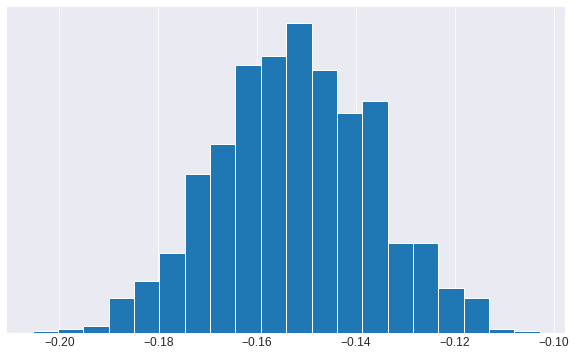

In [174]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(result2 , bins=20, edgecolor='w', density=True)
plt.yticks([]);

As you can see, the figure is quite similar, except that there is a minus sing. The next step would be the model checking, but it would be pointless (you could do it) and the results would not be right.

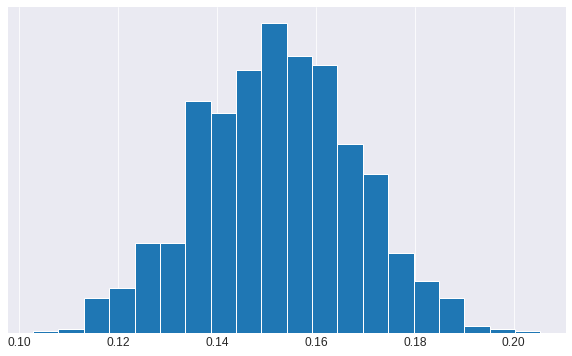

In [181]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(-result2 , bins=20, edgecolor='w', density=True) # With a minus
plt.yticks([]);

Why? I don't know, nevertheless, it is really weird.

In [117]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [118]:
%watermark -iv -v -p theano,scipy,matplotlib -m

numpy       1.17.4
pymc3       3.8
pandas      0.25.3
arviz       0.5.1
seaborn     0.9.0
pystan      2.19.0.0
CPython 3.6.9
IPython 7.6.1

theano 1.0.4
scipy 1.3.1
matplotlib 3.1.1

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-72-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


## **With pystan**

This section is to reproduce the figure 8.1 (a) and the figure 8.1 (b) with Stan.

In [3]:
import pystan
print(pystan.__version__)

2.19.0.0


In [64]:
modelo="""
data {
  int<lower=0> N;
  int<lower=0> n;
  int y_obs[N, n];
  vector[n] alpha;
}

parameters {
  
  simplex[n] theta[N];
}

model {
  
  for (i in 1:N)
    theta[i] ~ dirichlet(alpha);
  
  for (i in 1:N)
    y_obs[i] ~ multinomial(theta[i]);
}

"""

In [66]:
stan_modelo = pystan.StanModel(model_code=modelo)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2a28c5090c429737936718a5aee45413 NOW.


In [176]:
data2 = {'N': 16,
       'n': 3,
       'alpha': [1,1,1],
       'y_obs': valores.astype(int)}

In [177]:
fit = stan_modelo.sampling(data=data2)

In [178]:
print(fit.stansummary(digits_summary=5))

Inference for Stan model: anon_model_2a28c5090c429737936718a5aee45413.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1,1]  0.2991  0.0006 0.0648 0.1829 0.2522 0.2966 0.3427 0.4330   9140 0.9992
theta[2,1]  0.4897  0.0009 0.0695 0.3542  0.442 0.4900 0.5370 0.6221   5691 0.9992
theta[3,1]  0.4648  0.0004 0.0381 0.3924 0.4391 0.4640 0.4908 0.5395   8183 0.9991
theta[4,1]  0.4578  0.0006 0.0575 0.3446 0.4187 0.4574 0.4980 0.5702   7824 0.9995
theta[5,1]  0.4008  0.0008 0.0673 0.2730 0.3544 0.3998 0.4459 0.5341   7071 0.9996
theta[6,1]  0.4436  0.0006 0.0506 0.3463 0.4091 0.4438 0.4779 0.5423   6712 0.9992
theta[7,1]  0.5051  0.0005 0.0445 0.4156 0.4745 0.5061 0.5356 0.5891   7149 0.9995
theta[8,1]  0.5469  0.0004 0.0410 0.4673 0.5185 0.5464 0.5753 0.6270   7593 0.9993
theta[9,1]  0.5398  0.0011 0.0966 0.3465 0.4742 0.5425 0.6061 0.

In [179]:
samples = fit.extract(permuted=True)['theta']

In [183]:
np.mean(samples[:, 0, 2])

0.10047556624303831

In [184]:
diff3 = []

for i in range(16):
    result3 = samples[:, i, 0] - samples[:, i, 1]
    diff3.append(list(result3))

In [185]:
diff3 = np.asarray(diff3)
diff3

array([[-0.26316683, -0.46907552, -0.18810958, ...,  0.01134663,
        -0.02195103, -0.4870123 ],
       [ 0.04889463,  0.39351895, -0.1193489 , ..., -0.08524156,
         0.11291295, -0.03893748],
       [-0.10991316,  0.13760039,  0.14554263, ...,  0.10282834,
         0.02578634,  0.01062272],
       ...,
       [ 0.09066012,  0.06472593,  0.07636403, ...,  0.19946736,
         0.07081995,  0.20796647],
       [ 0.23329006,  0.29721636,  0.13941577, ...,  0.20717848,
         0.12005161,  0.24211568],
       [ 0.09777631,  0.23095916,  0.05175801, ...,  0.30393431,
         0.07606157,  0.15274686]])

In [186]:
res2 = np.sum(diff3.T * proportion / np.sum(proportion), axis=1)

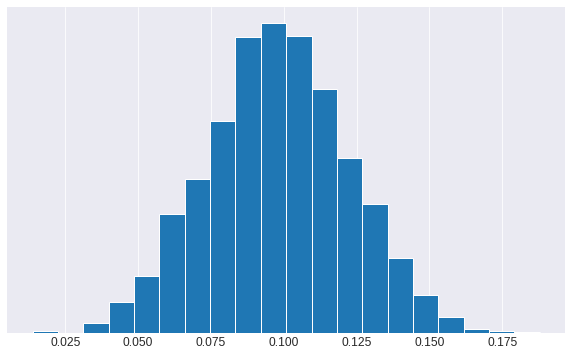

In [187]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(res2, bins=20, edgecolor='w', density=True)
plt.yticks([]);
# plt.savefig('model_non_hier.png', dpi=120)

With this, the figure 8.1 (a) is very similiar to this one.

### **Pystan with the hierarchical model**

In [4]:
modelo2="""
data {
  int<lower=0> N;
  int<lower=0> n;
  int post[N, n];
}

parameters {
  vector[n] mu;
  cholesky_factor_corr[n] L;
  simplex[n] alphas[N];
  vector[n] beta[N];
  
}

transformed parameters{
  
  vector[n] theta[N];
  
  for (i in 1:N)
    theta[i] = inv_logit(beta[i]);
    
   
}

model {

  L ~ lkj_corr_cholesky(3.0);
 
  mu ~ uniform(-5, 5);
  
  beta ~ multi_normal_cholesky(mu, L);
  
  
  for (i in 1:N)
    alphas[i] ~ dirichlet(theta[i]);
    
  for (i in 1:N)
    post[i] ~ multinomial(alphas[i]);
  
}

generated quantities {

  corr_matrix[n] Sigma;
  Sigma = multiply_lower_tri_self_transpose(L);
  
}


"""

In [5]:
stan_modelo2 = pystan.StanModel(model_code=modelo2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ffbf49915be317bed47428f1a01cfff8 NOW.


In [18]:
data3 = {'N': 16,
         'n': 2,
         'post': new_values.astype(int)}

In [96]:
fit2 = stan_modelo2.sampling(data=data3, iter=5000, verbose=True, control={'adapt_delta':0.90})

In [97]:
print(fit2.stansummary(digits_summary=5))

Inference for Stan model: anon_model_ffbf49915be317bed47428f1a01cfff8.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]        3.2259  0.0658 1.1490 0.8594 2.3988 3.3432 4.1962 4.9292    304 1.0180
mu[2]        3.6858  0.0391 0.9187 1.6463 3.0634 3.8291 4.4515 4.9458    550 1.0108
L[1,1]          1.0     nan    0.0    1.0    1.0    1.0    1.0    1.0    nan    nan
L[2,1]       0.0011  0.0131 0.3742 -0.695 -0.276-7.2306e-7 0.2743 0.7092    811 1.0027
L[1,2]          0.0     nan    0.0    0.0    0.0    0.0    0.0    0.0    nan    nan
L[2,2]       0.9223  0.0023 0.0961 0.6484 0.8880 0.9611 0.9906 0.9999   1734 1.0008
alphas[1,1]  0.2702  0.0010 0.0557 0.1717 0.2288 0.2675 0.3085 0.3838   2606 1.0017
alphas[2,1]  0.3501  0.0015 0.0570 0.2415 0.3110 0.3493 0.3885 0.4636   1332 1.0010
alphas[3,1]  0.3774  0.0008 0.0319 0.3161 0.3555 0.

In [98]:
samples2 = fit2.extract(permuted=True)['alphas']

In [99]:
th5 = []

for i in range(16):
    res5 =  2 * samples2[:, i, 0] * samples2[:, i, 1] - samples2[:, i, 1] 
#     result1 = - 2 * ppc_hier['alphas'][:, i, 0] * ppc_hier['alphas'][:, i, 1] + ppc_hier['alphas'][:, i, 1] 
    th5.append(list(result5))

In [100]:
th5 = np.asarray(th5)
th5.shape

(16, 8000)

In [101]:
result5 = np.sum(th5.T * proportion / np.sum(proportion), axis=1)
print(result5.shape)
result5[:15]

(8000,)


array([-0.11965072, -0.11812914, -0.164097  , -0.16740873, -0.18001722,
       -0.16055835, -0.07397384, -0.12309058, -0.06696517, -0.18929071,
       -0.11754521, -0.09852861, -0.20565993, -0.10907691, -0.16215137])

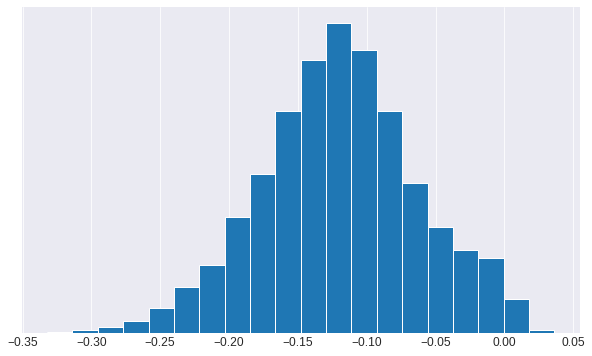

In [102]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(result5 , bins=20, edgecolor='w', density=True)
plt.yticks([]);
# plt.savefig('model_hier.png', dpi=120)

Again, very similar to the figure 8.1 (b), except for a minus sign. Why? It is not clear at the moment.